Reanylising the EUVE data using Lightkurve for consistancy with the TESS anlysis.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
from astropy.timeseries import LombScargle

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

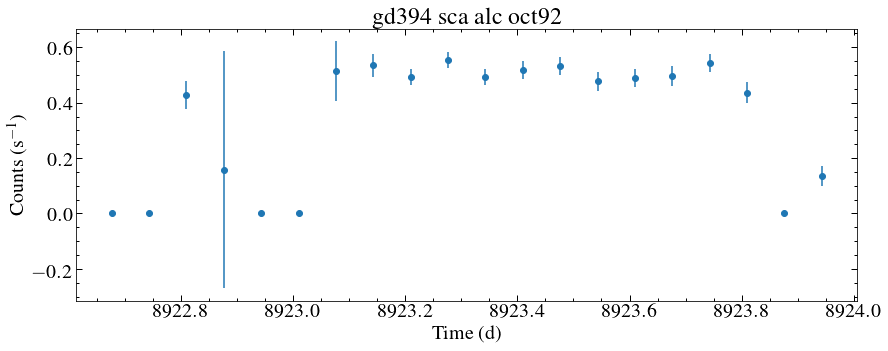

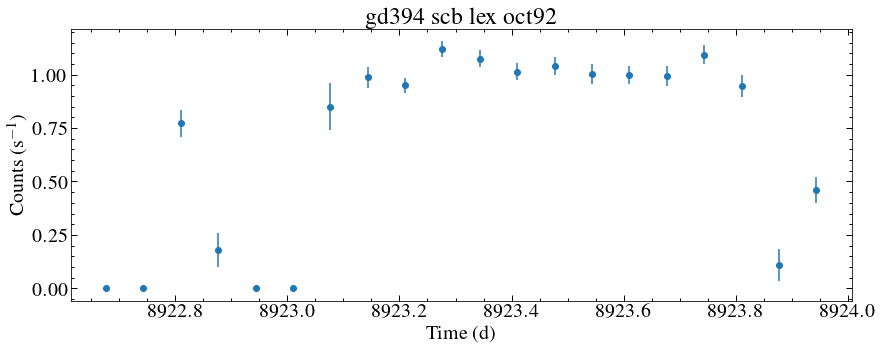

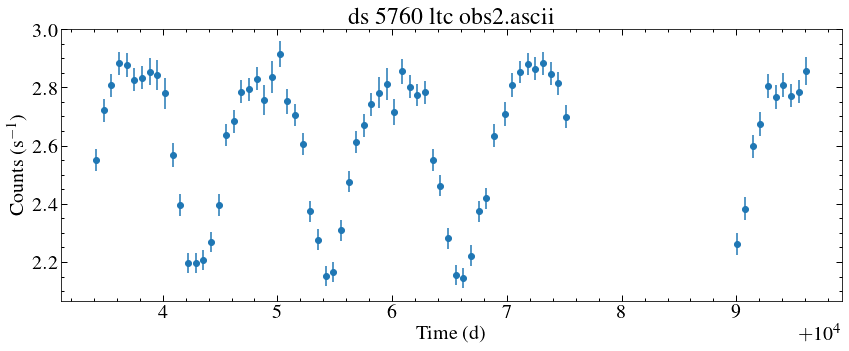

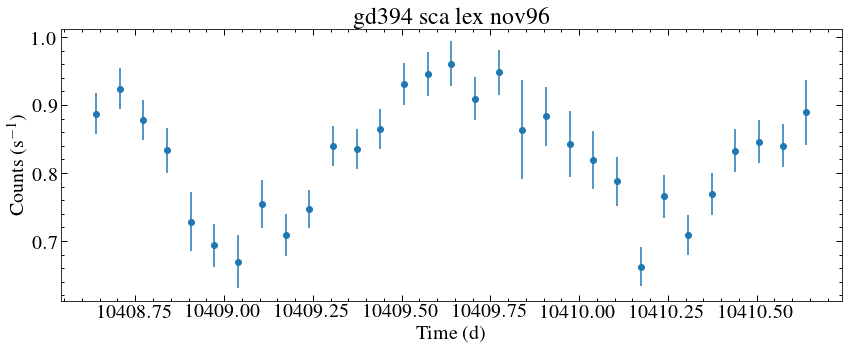

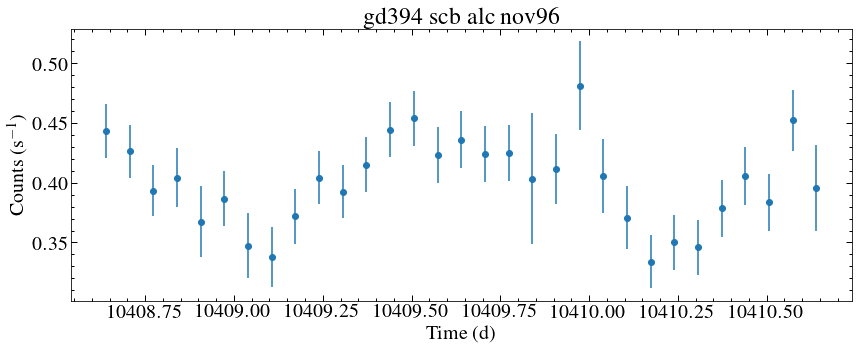

In [7]:
lcs = ['gd394_sca_alc_oct92', 'gd394_scb_lex_oct92', 'ds_5760_ltc_obs2.ascii', 'gd394_sca_lex_nov96', 'gd394_scb_alc_nov96']
#clear out the notebook files
for lc in lcs:
    plt.figure(lc)
    t, c, e = np.loadtxt(lc, unpack=True)
    plt.errorbar(t/86400., c, yerr=e, marker='o', ls='none')
    plt.title(lc.replace('_',' '))
    plt.xlabel('Time (d)')
    plt.ylabel('Counts (s$^{-1}$)')

In [3]:
#first two aren't any good
euvelcs=lcs[2:]
euvelcs

['ds_5760_ltc_obs2.ascii', 'gd394_sca_lex_nov96', 'gd394_scb_alc_nov96']

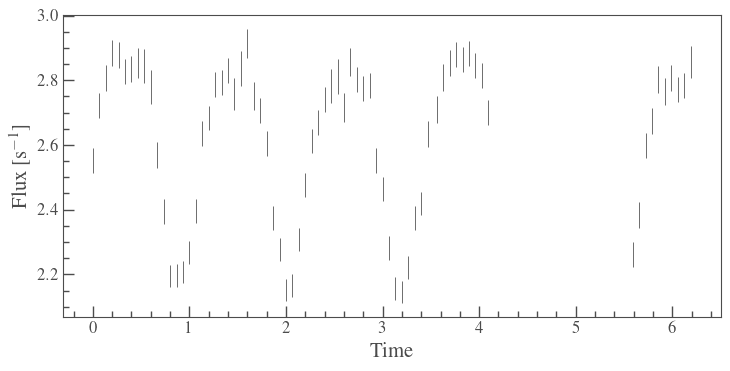

Model: CompoundModel75
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Lorentz1D(amplitude=0.3, x_0=1.15, fwhm=1.)>

    [1]: <Const1D(amplitude=0.)>
Parameters:
       amplitude_0           x_0_0               fwhm_0           amplitude_1     
          1 / s                d                   d                 1 / s        
    ------------------ ------------------ ------------------- --------------------
    0.3104268795069342 1.1779137085139346 0.29542858780638853 0.008552703764381837
Parameter('x_0', value=1.1779137085139346, unit=d) 0.003270556925222565


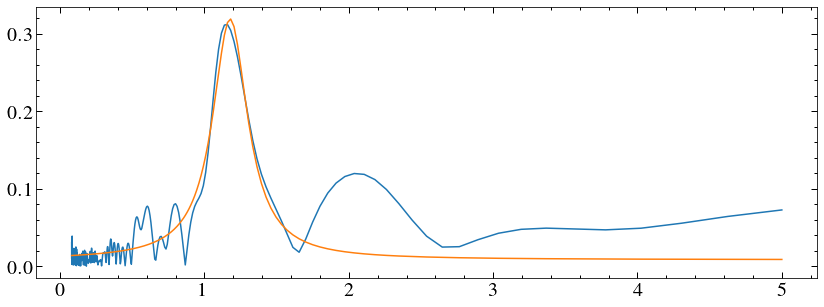

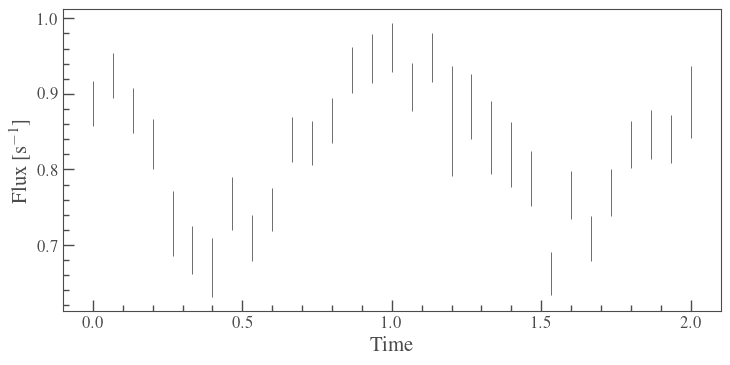

Model: CompoundModel76
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Lorentz1D(amplitude=0.3, x_0=1.15, fwhm=1.)>

    [1]: <Const1D(amplitude=0.)>
Parameters:
        amplitude_0           x_0_0             fwhm_0            amplitude_1     
           1 / s                d                 d                  1 / s        
    ------------------- ----------------- ------------------ ---------------------
    0.11645190924427413 1.236209002835433 0.7033947035369685 0.0004404858922997918


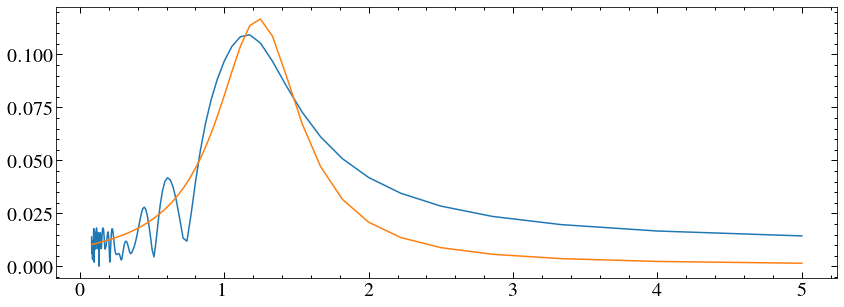

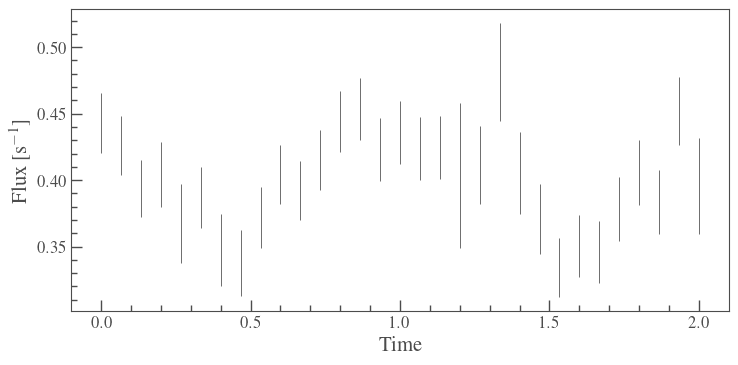

Model: CompoundModel77
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Lorentz1D(amplitude=0.3, x_0=1.15, fwhm=1.)>

    [1]: <Const1D(amplitude=0.)>
Parameters:
        amplitude_0           x_0_0              fwhm_0           amplitude_1     
           1 / s                d                  d                 1 / s        
    ------------------- ------------------ ------------------ --------------------
    0.03580623376883415 1.2754586677861357 0.8553076990758095 0.002885135120673429


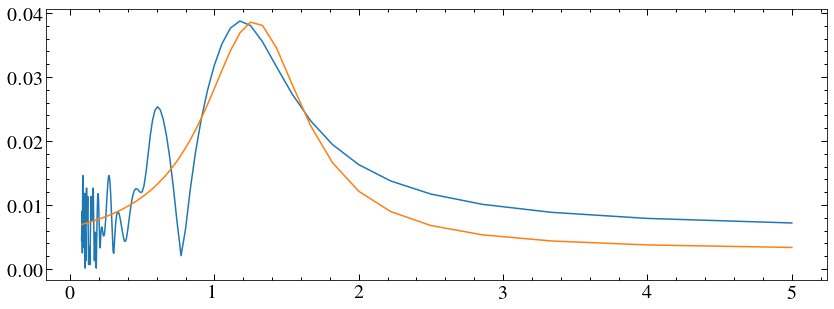

In [55]:
fitter = fitting.LevMarLSQFitter()
mid_times = []
for i, lcf in enumerate(euvelcs):
    t, c, e = np.loadtxt(lcf, unpack=True)
    t /=86400
    mid_times.append(t[int(len(t)/2)])
    t -=t[0]
    lc = lk.LightCurve(time=t*u.day, flux=c*(1/u.s), flux_err=e*(1/u.s) )
    lc.errorbar()
    plt.show()
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=0.08*u.day, maximum_period=5*u.day)
    #pg.plot()
    l_init =  models.Lorentz1D(0.3, 1.15, fwhm=1.0)+models.Const1D(0)
    l_fit=fitter(l_init, pg.period, pg.power, maxiter=1000000)
    print(l_fit)
    if i == 0:
        fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
        print(l_fit[0].x_0, fit_e[1])
    plt.plot(pg.period, pg.power)
    plt.plot(pg.period, l_fit(pg.period))
    plt.show()

Ok, bottom two are unfittable, for the first I get p $= 1.18 \pm 0.004$ - same as D+00 but with samller error. Sin fits to the lightcurves?

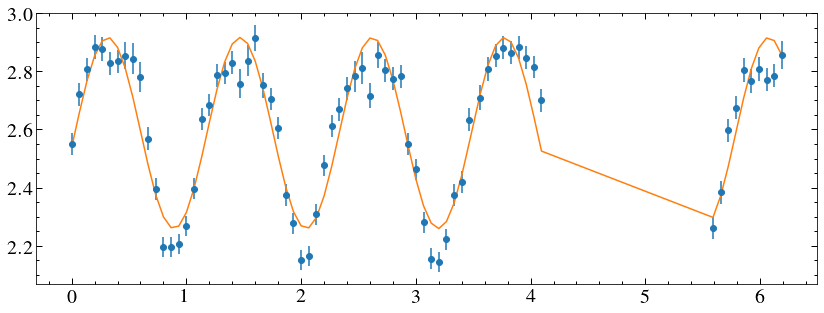

1.1520914540964151 0.005391331686557548


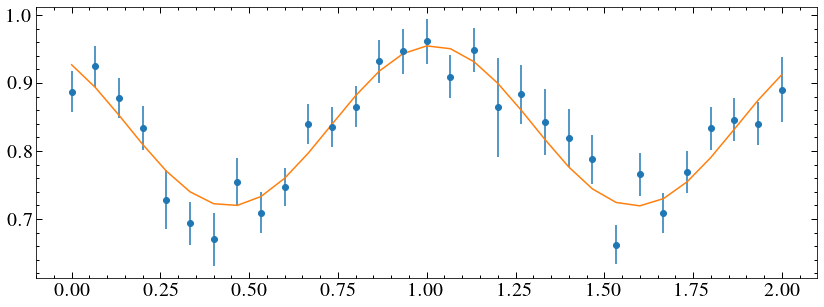

1.1443047361111118 0.02578639805256271


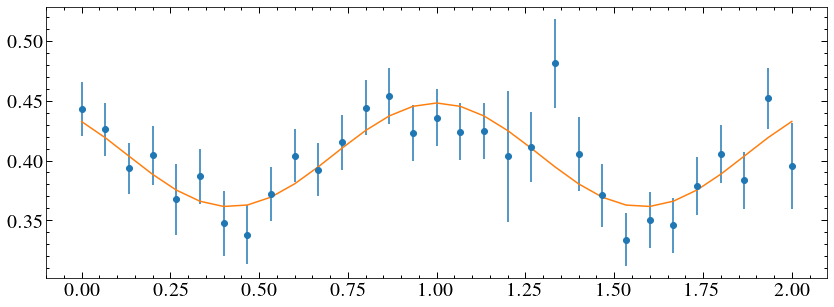

1.1611752853350865 0.044398107219586834


In [45]:
fitter = fitting.LevMarLSQFitter()
mid_times = []
periods = []
errors = []
for i, lcf in enumerate(euvelcs):
    t, c, e = np.loadtxt(lcf, unpack=True)
    t /=86400
    mid_times.append(t[int(len(t)/2)])
    t -=t[0]
   # e /= np.median(c)
   #c /= np.median(c)
    #mask = (t < 5)
    #t, c, e = t[mask], c[mask], e[mask]
    plt.errorbar(t, c, yerr=e, marker='o', ls='none')
    sin_mod =  models.Sine1D(amplitude=1, frequency=1/1.15)+models.Const1D(1.0)#, fixed={'amplitude':1.0})
    sin_fit = fitter(sin_mod, t, c,  weights=1/e, maxiter=100000)
    plt.plot(t, sin_fit(t))
    plt.show()
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    print(1/sin_fit[0].frequency, fit_e[1]/sin_fit[0].frequency**2)
    periods.append([1/sin_fit[0].frequency])
    errors.append(fit_e[1]/sin_fit[0].frequency**2)
    

<ErrorbarContainer object of 3 artists>

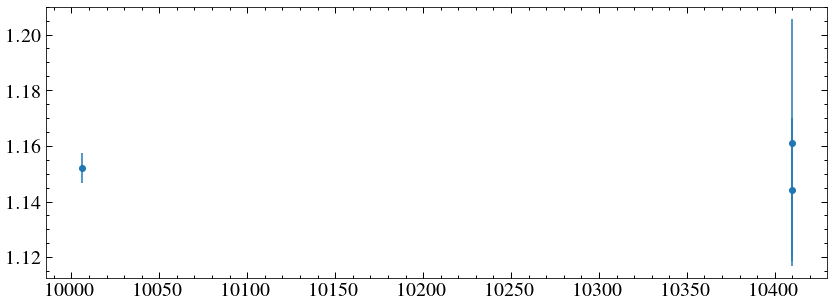

In [38]:
plt.errorbar(mid_times, periods, yerr=errors, marker='o', ls='none')

Not sure if I'm going to improve on the D+00 result really.